# Aqualab Validation Logistic Regression Analysis Rewrite

After meeting with Stefan and Rachel, some new insights were revealed about the validity of our data and analysis.

---
### Stuff to keep:
- Point-biserial is a valid corr coeff for binary against ordinal data
- Logistic regression is valid model for this type of data
- Corr coeffs above 0.2-0.25 are meaningful enough to be explored in future analysis
- Despite initial concerns that we were unable to form a sigmoid curve with our data, according to Stefan this isn't actually essential for our analysis(ask why in follow-up)
- We should have enough true positives in our feature data to not have to worry about augmentation(and this wouldn't work anyways)

### Stuff to improve:
- Original EMA modeling data contain several "rogue" decimal values.
- Use benjamini hochberg to reduce alpha across lots of tests and reduce the risk of Type 1 Errors
- Change buckets for EMA data, try quartiles/binary?
- Current Logistic Regression output is weird in the 3-4 value printout
---


## TODO:
The goal of this notebook is to improve on our analysis from Stefan's notes in the last meeting. The main goals include:

- Fix "rogue" ordinal values and re-run logistic regression and point-biserial corr coefficient calculations. Check if this fixes weird readouts in our logistic regression.
- Create new buckets for EMA values, both binary and smaller ordinal pools. Visualize these distributions with histograms
- For distributions of particular importance, use a [means diamond plot](https://https://stats.stackexchange.com/questions/190091/how-to-illustrate-correlation-in-binary-classification) to visualize the distribution of the corr data
- Use benjamini hochberg for all correlation coefficient calculations to reduce the risk of Type I errors.
- Systemtically re-run logistic regression model analysis




## Part 1: Fixing Faulty EMA data
Let's start by fixing our faulty EMA ordinal values and rerunning our existing analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rfpimp
!pip install mord
!pip install pypair
!pip install phik
!pip install MASS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix

from scipy.stats import kendalltau

import scipy.stats as stats
import statistics

import sklearn
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from tensorflow import keras
from sklearn import linear_model
from scipy.stats import chi2


import statsmodels.api as sm

import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from pypair.association import binary_continuous


import json
import urllib.request as ur
from collections import Counter
from io import BytesIO
from math import ceil, pi
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
from mord import LogisticAT

import statsmodels.api as sm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached mass-0.1.4.tar.gz (4.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached distribute-0.7.3.zip (145 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
## Load in feature values and columns from tsv

ply_features = pd.read_csv("/content/drive/MyDrive/AqualabValidation_Zach/featuredata/AQUALAB_20220601_to_20220715_c2ad3af_player-features.tsv", sep = "	").dropna()
#remove NA values
ply_features = ply_features.loc[ply_features.PlayerID.isna() != True]

id_col = ['PlayerID']
job_col = []
aggr_col = []
for col in ply_features.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job'):
    job_col.append(pieces[1])
  else:
    aggr_col.append(col)
job_col = Counter(job_col)
print(f"{len(ply_features.columns)} perjobfeatures in {len(job_col)} groups:")
pprint(job_col, compact=False)

job_col = [key for key in job_col.keys() if key.startswith('Job')]
aggr_col = aggr_col[1:]
pprint(aggr_col)


1272 perjobfeatures in 22 groups:
Counter({'JobActiveTime': 57,
         'JobArgumentationTime': 57,
         'JobCompletionTime': 57,
         'JobDiveSitesCount': 57,
         'JobDiveTime': 57,
         'JobExperimentationTime': 57,
         'JobGuideCount': 57,
         'JobHelpCount': 57,
         'JobHelpCount-ByTask': 57,
         'JobLocationChanges': 57,
         'JobLocationChanges-ByTask': 57,
         'JobModelingTime': 57,
         'JobTasksCompleted': 57,
         'SyncCompletionTime': 57,
         'JobsAttempted': 57,
         'JobsAttempted-job-name': 57,
         'JobsAttempted-num-starts': 57,
         'JobsAttempted-num-completes': 57,
         'JobsAttempted-percent-complete': 57,
         'JobsAttempted-avg-time-per-attempt': 57,
         'JobsAttempted-std-dev-per-attempt': 57,
         'JobsAttempted-job-difficulties': 57})
['ActiveTime',
 'JobsCompleted',
 'SessionDiveSitesCount',
 'SessionDuration',
 'SessionGuideCount',
 'SessionHelpCount',
 'SessionID',
 'Ses

In [ ]:
# import job complexity scores
DBexport = json.load(open("/content/drive/MyDrive/AqualabValidation_Zach/DBExport.json"))
Complexity_df = pd.DataFrame(columns=['job_id', 'job_name', 'argumentation', 'experimentation', 'modeling'])
for id, job in enumerate(DBexport.get('jobs')):
  Complexity_df.loc[len(Complexity_df.index)] = [id, job['id'], job['difficulties']['argumentation'],
                                                 job['difficulties']['experimentation'],
                                                 job['difficulties']['modeling']]

# import player complexity scores
labels = pd.read_excel("/content/drive/MyDrive/AqualabValidation_Zach/surveydata/Aqualab Practices Survey June 2022 scores final.xlsx",
                       sheet_name='Simplified')
labels = labels.rename({'Modeling_score_max_5)':'Modeling_score_max_5'}, axis='columns')

player_complexity = pd.merge(ply_features, labels, left_on="PlayerID", right_on="user_code", how="inner")


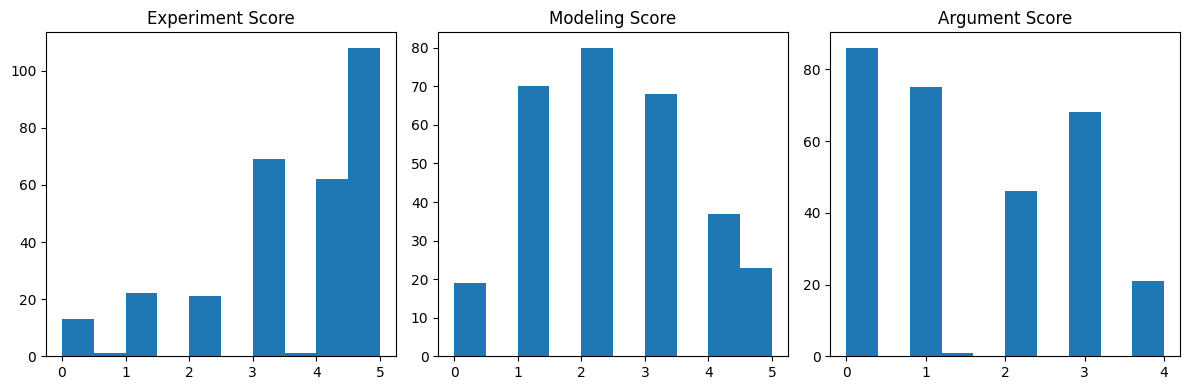

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = labels['Experiment_score_max_5']
modeling_score = labels['Modeling_score_max_5']
argument_score = labels['Argument_score_max_4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

In [ ]:
print(modeling_score.value_counts())
print(experiment_score.value_counts())
print(argument_score.value_counts())

2.000000    79
1.000000    70
3.000000    68
4.000000    37
5.000000    23
0.000000    18
2.355932     1
0.471186     1
Name: Modeling_score_max_5, dtype: int64
5.000000    108
3.000000     69
4.000000     62
1.000000     22
2.000000     21
0.000000     13
3.589831      1
0.717966      1
Name: Experiment_score_max_5, dtype: int64
0.000000    85
1.000000    75
3.000000    68
2.000000    46
4.000000    21
1.542373     1
0.385593     1
Name: Argument_score_max_4, dtype: int64


We clearly have some non-ordinal data in this ordinal dataset. Let's reformat everything and convert our floats to int, then re-run our existing analysis

In [ ]:
player_complexity['Experiment_score_max_5'] = player_complexity['Experiment_score_max_5'].round().astype(int)
player_complexity['Modeling_score_max_5'] = player_complexity['Modeling_score_max_5'].round().astype(int)
player_complexity['Argument_score_max_4'] = player_complexity['Argument_score_max_4'].round().astype(int)

print(player_complexity['Experiment_score_max_5'].value_counts())
print(player_complexity['Modeling_score_max_5'].value_counts())
print(player_complexity['Argument_score_max_4'].value_counts())

5    59
3    47
4    33
2    13
1    13
0     4
Name: Experiment_score_max_5, dtype: int64
1    47
2    47
3    31
4    22
5    12
0    10
Name: Modeling_score_max_5, dtype: int64
1    51
0    48
3    38
2    22
4    10
Name: Argument_score_max_4, dtype: int64


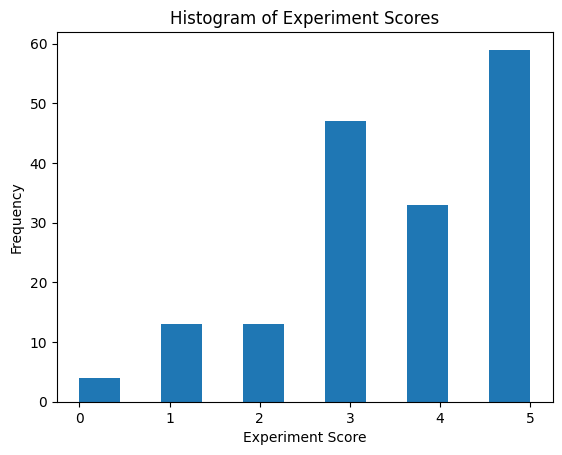

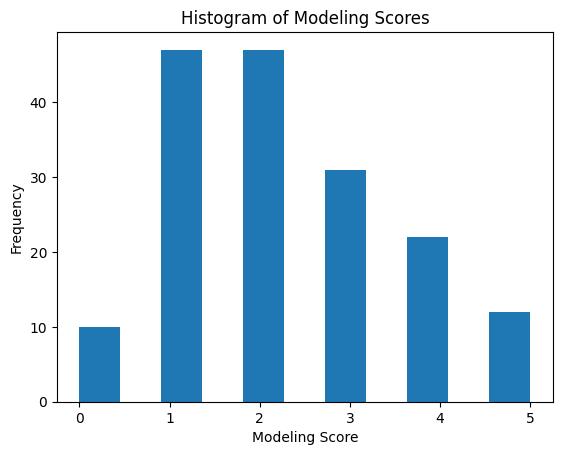

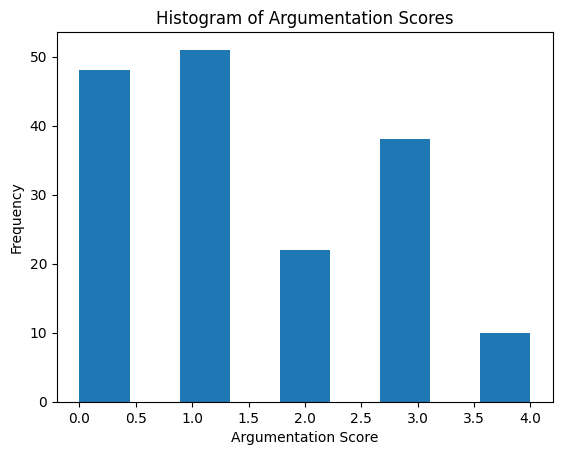

In [ ]:
plt.hist(player_complexity['Experiment_score_max_5'], bins=11)  # Adjust the number of bins as per your preference

# Add labels and title to the plot
plt.xlabel('Experiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Experiment Scores')

# Display the histogram
plt.show()

###########


plt.hist(player_complexity['Modeling_score_max_5'], bins=11)  # Adjust the number of bins as per your preference

# Add labels and title to the plot
plt.xlabel('Modeling Score')
plt.ylabel('Frequency')
plt.title('Histogram of Modeling Scores')

# Display the histogram
plt.show()


##############
plt.hist(player_complexity['Argument_score_max_4'], bins=9)  # Adjust the number of bins as per your preference

# Add labels and title to the plot
plt.xlabel('Argumentation Score')
plt.ylabel('Frequency')
plt.title('Histogram of Argumentation Scores')

# Display the histogram
plt.show()


## Part 2: benjamini hochberg procedure

By using the [benjamini hochberg procedure](https://www.statisticshowto.com/benjamini-hochberg-procedure/) we can reduce the risk of Type I errors in our analysis. Let's first run our normal corr coefficient calculations with point-biserial and then calculate the benjamini-hochberg statistics for each p-value. For the sake of the simplicity of this analysis, we'll focus exclusively on _JobTasksCompleted features.

In [ ]:
df = player_complexity

correlation_columns = ['Experiment_score_max_5', 'Modeling_score_max_5', 'Argument_score_max_4']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.01 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

job12_JobTasksCompleted: 0.27596723117702604, 0.0002815261453787398, Argument_score_max_4
job13_JobTasksCompleted: 0.26122532016646816, 0.0006024977234329746, Argument_score_max_4
job15_JobTasksCompleted: 0.23031542931683946, 0.0025911818517876904, Modeling_score_max_5
job32_JobTasksCompleted: 0.22735292324339104, 0.0029521059593463302, Modeling_score_max_5
job32_JobTasksCompleted: 0.22344008294175363, 0.0034983536026067727, Argument_score_max_4
job36_JobTasksCompleted: 0.20253391247952995, 0.008270406792772174, Argument_score_max_4


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## Benjamini Hochberg statistics for point-biserial coefficients

(m = 36, number of original p-tests with "Job")
TODO: check with Stefan on what value to use for m and rerun in [this spreadsheet](https://https://docs.google.com/spreadsheets/d/16yXW8cZxCFaMOJR2wmWU17MDaI2Ge_bt3LWYEudF3lo/edit?usp=sharing) if necessary.

### Table Data
| Variable | P-Value | Rank | (I/m)Q | EMA response value |
| --- | --- | --- | --- | --- |
| job12_JobTasksCompleted | 0.0002815261454 | 1 | 0.006944444444 | Argument |
| job13_JobTasksCompleted | 0.0006024977234 | 2 | 0.01388888889 | Modeling |
| job15_JobTasksCompleted | 0.002591181852 | 3 | 0.02083333333 | Modeling |
| job32_JobTasksCompleted | 0.003498353603 | 4 | 0.03333333333 | Argument |
| job36_JobTasksCompleted | 0.008270406793 | 5 | 0.03472222222 | Argument |


With m of 36, all of our adjusted benjamini-hochberg statistic values are still sufficiently below an alpha of 0.05. Even when setting m to 5, our top 2 ranked p-values are still sufficiently below alpha. We can be relatively positive that these results are not a Type I error.



## Part 3: Re-running Logistic Regression Models with corrected Ordinal Values

Now that we have corrected ordinal values for our EMA scores, let's run these through our logit model and see if we have better looking outputs.

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.449796
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -245.02
Model:                     OrderedModel   AIC:                             500.0
Method:              Maximum Likelihood   BIC:                             515.7
Date:                  Tue, 18 Jul 2023                                         
Time:                          04:25:36                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     1.7807      0.508      3.505      0.000       0.785       2.776
0/1                        -0.8234      0.174     -4.734      0.000      -1.164      -0.482
1/2                         0.2800      0.125      2.243      0.025       0.035       0.525
2/3                        -0.4804      0.202     -2.378      0.017      -0.876      -0.084
3/4                         0.6753      0.163      4.145      0.000       0.356       0.995
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5'],
                        df[['job13_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.632588
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Modeling_score_max_5   Log-Likelihood:                -275.91
Model:                     OrderedModel   AIC:                             563.8
Method:              Maximum Likelihood   BIC:                             582.6
Date:                  Tue, 18 Jul 2023                                         
Time:                          04:25:42                                         
No. Observations:                   169                                         
Df Residuals:                       163                                         
Df Model:                             6                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     1.0900      0.580      1.880      0.060      -0.046       2.226
0/1                        -2.7237      0.327     -8.333      0.000      -3.364      -2.083
1/2                         0.7464      0.147      5.074      0.000       0.458       1.035
2/3                         0.1481      0.131      1.131      0.258      -0.109       0.405
3/4                        -0.0967      0.168     -0.575      0.565      -0.426       0.233
4/5                         0.1845      0.210      0.877      0.381      -0.228       0.597
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5'],
                        df[['job15_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.619197
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Modeling_score_max_5   Log-Likelihood:                -273.64
Model:                     OrderedModel   AIC:                             559.3
Method:              Maximum Likelihood   BIC:                             578.1
Date:                  Tue, 18 Jul 2023                                         
Time:                          04:25:47                                         
No. Observations:                   169                                         
Df Residuals:                       163                                         
Df Model:                             6                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job15_JobTasksCompleted     1.4519      0.514      2.825      0.005       0.445       2.459
0/1                        -2.6965      0.327     -8.244      0.000      -3.338      -2.055
1/2                         0.7491      0.147      5.101      0.000       0.461       1.037
2/3                         0.1627      0.131      1.242      0.214      -0.094       0.419
3/4                        -0.0692      0.168     -0.412      0.681      -0.399       0.260
4/5                         0.2088      0.210      0.996      0.319      -0.202       0.620
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.462297
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -247.13
Model:                     OrderedModel   AIC:                             504.3
Method:              Maximum Likelihood   BIC:                             519.9
Date:                  Tue, 18 Jul 2023                                         
Time:                          04:25:52                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     1.9615      0.683      2.872      0.004       0.623       3.300
0/1                        -0.8661      0.172     -5.024      0.000      -1.204      -0.528
1/2                         0.2605      0.125      2.085      0.037       0.016       0.505
2/3                        -0.5112      0.202     -2.533      0.011      -0.907      -0.116
3/4                         0.6640      0.164      4.045      0.000       0.342       0.986
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job36_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.467777
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -248.05
Model:                     OrderedModel   AIC:                             506.1
Method:              Maximum Likelihood   BIC:                             521.8
Date:                  Tue, 18 Jul 2023                                         
Time:                          04:26:01                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job36_JobTasksCompleted     1.7244      0.674      2.559      0.010       0.404       3.045
0/1                        -0.8759      0.172     -5.087      0.000      -1.213      -0.538
1/2                         0.2621      0.125      2.099      0.036       0.017       0.507
2/3                        -0.5113      0.202     -2.533      0.011      -0.907      -0.116
3/4                         0.6436      0.164      3.934      0.000       0.323       0.964
===========================================================================================
"""

## Part 4: New buckets for logit regression
Clearly something in our data is causing us to get weird values for the penultimate value in our logit output for the log odds value. Let's try doing some different permutations for buckets and see if we can get rid of the data issue. NOTE: later, we should go and figure out what specifically is causing this behavior so that we can explain it in a paper/abstract, but for now, let's just try and rectify the issue.

### Permutation 1(_tri_bucket): Combine middle values for an n=3 ordinal dataset

Since we're getting issues with some of our middle values, let's try combining columns 2...n-1 and see if this helps(so we'll get "low", "med", "high" at 1, 2, 3 for all). This will also help to standardize our argumentation data with the other two measures.

#### Permutation 1 Lambda Criteria:

- Lowest possible value keeps 1
- Values between 1 and n-1 get 2
- Highest value gets 3

In [ ]:
# Create new column for 'Modeling_score_max_5'
df['Modeling_score_max_5_tri_bucket'] = df['Modeling_score_max_5'].apply(lambda x: 1 if x == 1 else (2 if 1 < x < 5 else 3))

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_tri_bucket'] = df['Argument_score_max_4'].apply(lambda x: 1 if x == 1 else (2 if 1 < x < 4 else 3))

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_tri_bucket'] = df['Experiment_score_max_5'].apply(lambda x: 1 if x == 1 else (2 if 1 < x < 5 else 3))



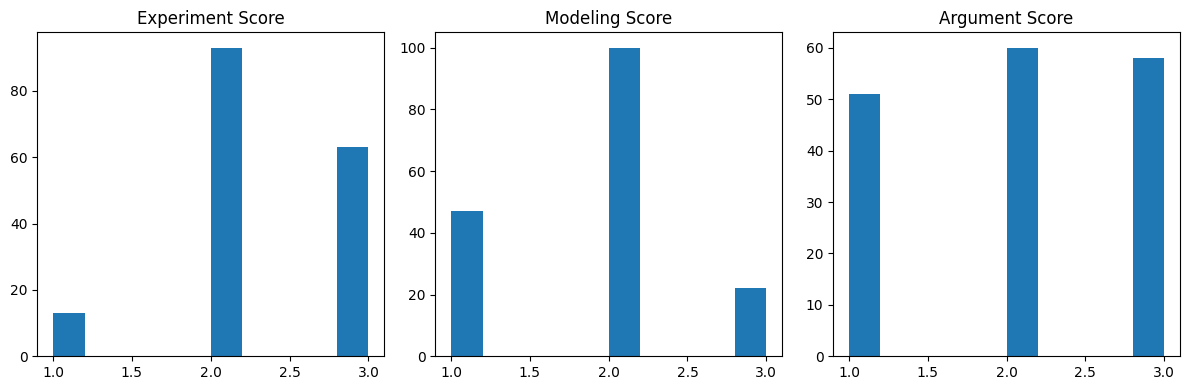

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = df['Experiment_score_max_5_tri_bucket']
modeling_score = df['Modeling_score_max_5_tri_bucket']
argument_score = df['Argument_score_max_4_tri_bucket']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

Now lets rerun our benjamini hochberg correlation coeff measures for point-biserial...

In [ ]:

correlation_columns = ['Experiment_score_max_5_tri_bucket', 'Modeling_score_max_5_tri_bucket', 'Argument_score_max_4_tri_bucket']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.statistic > 0.1: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


job10_JobTasksCompleted: 0.10002524294954213, 0.19569133268133648, Modeling_score_max_5_tri_bucket
job11_JobTasksCompleted: 0.14036955335162474, 0.06871575910416523, Modeling_score_max_5_tri_bucket
job12_JobTasksCompleted: 0.17512377447724484, 0.02276588399550242, Modeling_score_max_5_tri_bucket
job13_JobTasksCompleted: 0.18071386375370738, 0.018711132279790495, Modeling_score_max_5_tri_bucket
job15_JobTasksCompleted: 0.17512377447724484, 0.02276588399550242, Modeling_score_max_5_tri_bucket
job17_JobTasksCompleted: 0.11123317773310641, 0.14993216422514555, Modeling_score_max_5_tri_bucket
job18_JobTasksCompleted: 0.10442082681790905, 0.1766657962922881, Modeling_score_max_5_tri_bucket
job20_JobTasksCompleted: 0.10194666140841706, 0.18719935626741396, Experiment_score_max_5_tri_bucket
job28_JobTasksCompleted: 0.10137998862403948, 0.1896753128000079, Modeling_score_max_5_tri_bucket
job29_JobTasksCompleted: 0.1539104893235734, 0.04572672212107154, Modeling_score_max_5_tri_bucket
job32_JobT

This didn't produce great output- let's try grouping top two together


In [ ]:
# Create new column for 'Modeling_score_max_5'
df['Modeling_score_max_5_tri_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 1 if x == 1 else (2 if 1 < x < 4 else 3))

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_tri_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 1 if x == 1 else (2 if 1 < x < 3 else 3))

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_tri_bucket_2'] = df['Experiment_score_max_5'].apply(lambda x: 1 if x == 1 else (2 if 1 < x < 4 else 3))



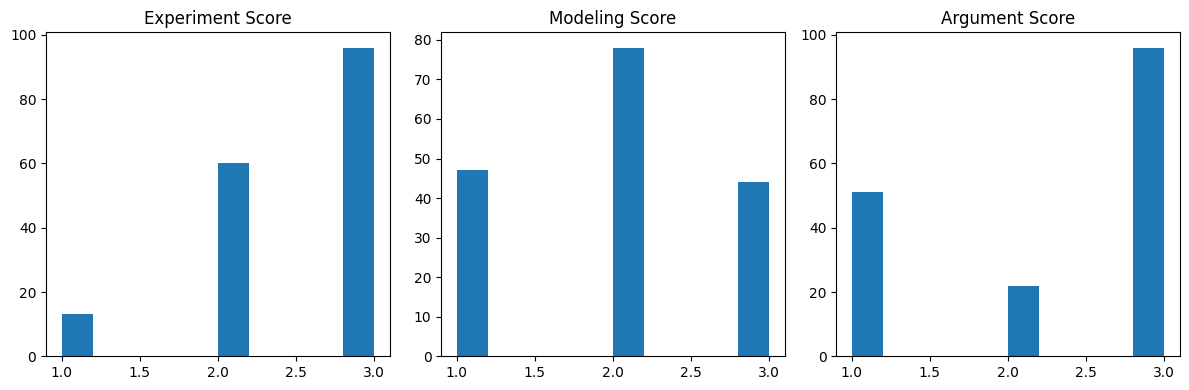

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = df['Experiment_score_max_5_tri_bucket_2']
modeling_score = df['Modeling_score_max_5_tri_bucket_2']
argument_score = df['Argument_score_max_4_tri_bucket_2']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

And recalculate...

In [ ]:

correlation_columns = ['Experiment_score_max_5_tri_bucket_2', 'Modeling_score_max_5_tri_bucket_2', 'Argument_score_max_4_tri_bucket_2']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.05 and pbs.statistic > 0.1: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


job10_JobTasksCompleted: 0.176999710940202, 0.021328054950735434, Modeling_score_max_5_tri_bucket_2
job15_JobTasksCompleted: 0.15358783521498387, 0.04618830893916533, Modeling_score_max_5_tri_bucket_2
job32_JobTasksCompleted: 0.15732696862225587, 0.041071164591988736, Modeling_score_max_5_tri_bucket_2


Let's skip Benjamini Hochberg for now and see how these statistically significant results hold up in logit regression

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5_tri_bucket_2'],
                        df[['job10_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.048093
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OrderedModel Results                                    
=============================================================================================
Dep. Variable:     Modeling_score_max_5_tri_bucket_2   Log-Likelihood:                -177.13
Model:                                  OrderedModel   AIC:                             360.3
Method:                           Maximum Likelihood   BIC:                             369.6
Date:                               Tue, 18 Jul 2023                                         
Time:                                       04:35:45                                         
No. Observations:                                169                                         
Df Residuals:                                    166                                         
Df Model:                                          3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job10_JobTasksCompleted     1.3453      0.610      2.206      0.027       0.150       2.540
1/2                        -0.8913      0.174     -5.117      0.000      -1.233      -0.550
2/3                         0.7144      0.098      7.285      0.000       0.522       0.907
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5_tri_bucket_2'],
                        df[['job15_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.051658
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OrderedModel Results                                    
=============================================================================================
Dep. Variable:     Modeling_score_max_5_tri_bucket_2   Log-Likelihood:                -177.73
Model:                                  OrderedModel   AIC:                             361.5
Method:                           Maximum Likelihood   BIC:                             370.9
Date:                               Tue, 18 Jul 2023                                         
Time:                                       04:35:52                                         
No. Observations:                                169                                         
Df Residuals:                                    166                                         
Df Model:                                          3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job15_JobTasksCompleted     1.0103      0.518      1.950      0.051      -0.005       2.026
1/2                        -0.8837      0.175     -5.038      0.000      -1.227      -0.540
2/3                         0.7099      0.098      7.240      0.000       0.518       0.902
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5_tri_bucket_2'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.051283
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OrderedModel Results                                    
=============================================================================================
Dep. Variable:     Modeling_score_max_5_tri_bucket_2   Log-Likelihood:                -177.67
Model:                                  OrderedModel   AIC:                             361.3
Method:                           Maximum Likelihood   BIC:                             370.7
Date:                               Tue, 18 Jul 2023                                         
Time:                                       04:36:00                                         
No. Observations:                                169                                         
Df Residuals:                                    166                                         
Df Model:                                          3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     1.3238      0.676      1.959      0.050      -0.001       2.648
1/2                        -0.9045      0.174     -5.209      0.000      -1.245      -0.564
2/3                         0.7096      0.098      7.244      0.000       0.518       0.902
===========================================================================================
"""

### Summary of tri_bucket_2 analysis

This produced some slightly better numbers... but why are we now getting worse p-values?

Looking back at our logit prediction models could potentially yield some insight into the distribution of these data in different types of buckets...

## Analysis of logit plots for bucket comparisons

Let's compare successful and unsuccessful logits for different bucket types(ignore the line, the dot plot is the primary focus)

### Tri_bucket_2 logits

Optimization terminated successfully.
         Current function value: 0.208232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177615
         Iterations 8


Text(0, 0.5, 'job32_JobTasksCompleted')

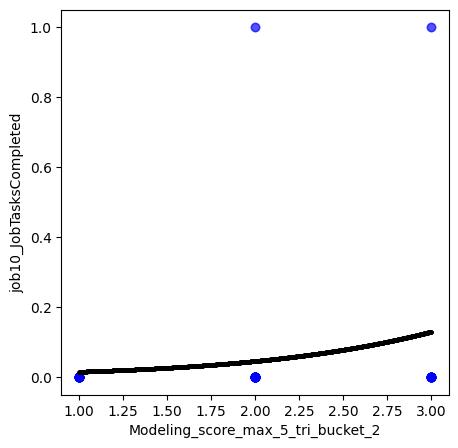

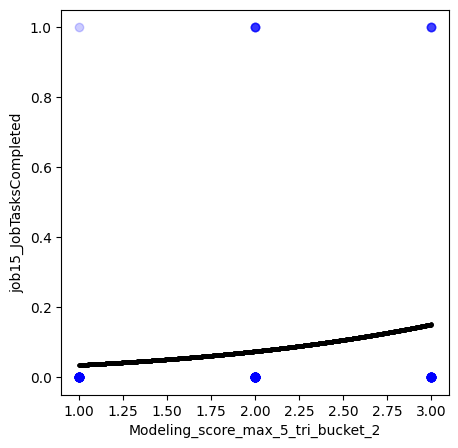

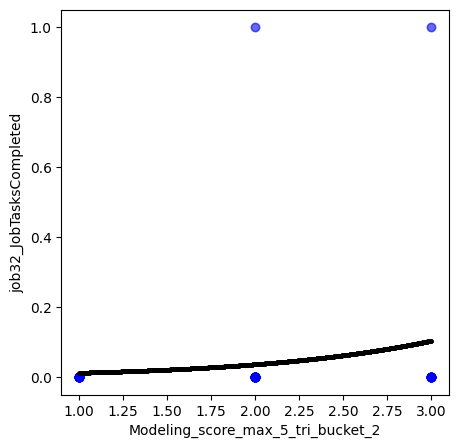

In [ ]:
## JOB 10
pred = 'job10_JobTasksCompleted'
res = 'Modeling_score_max_5_tri_bucket_2'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 15


pred = 'job15_JobTasksCompleted'
res = 'Modeling_score_max_5_tri_bucket_2'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



## JOB 32

pred = 'job32_JobTasksCompleted'
res = 'Modeling_score_max_5_tri_bucket_2'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)




### Tri_bucket_1 logits

Optimization terminated successfully.
         Current function value: 0.219699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.270237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180407
         Iterations 8


Text(0, 0.5, 'job32_JobTasksCompleted')

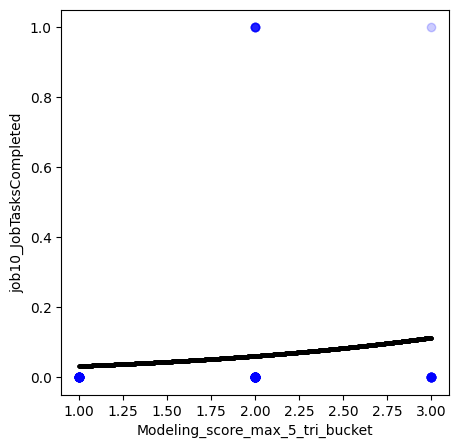

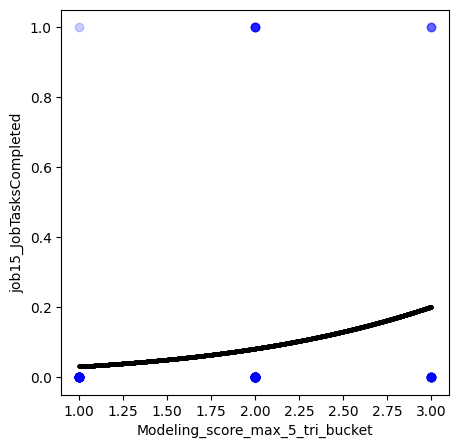

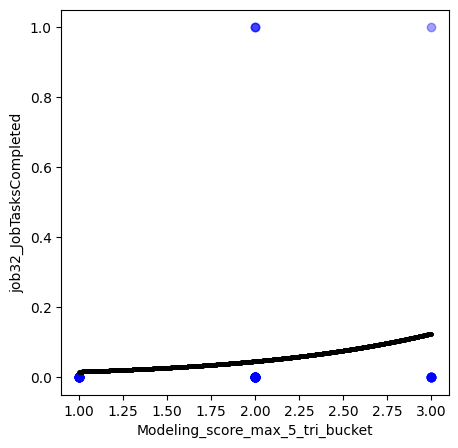

In [ ]:
## JOB 10
pred = 'job10_JobTasksCompleted'
res = 'Modeling_score_max_5_tri_bucket'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 15


pred = 'job15_JobTasksCompleted'
res = 'Modeling_score_max_5_tri_bucket'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



## JOB 32

pred = 'job32_JobTasksCompleted'
res = 'Modeling_score_max_5_tri_bucket'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)




Default-bucket logits

Optimization terminated successfully.
         Current function value: 0.206491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165710
         Iterations 8


Text(0, 0.5, 'job32_JobTasksCompleted')

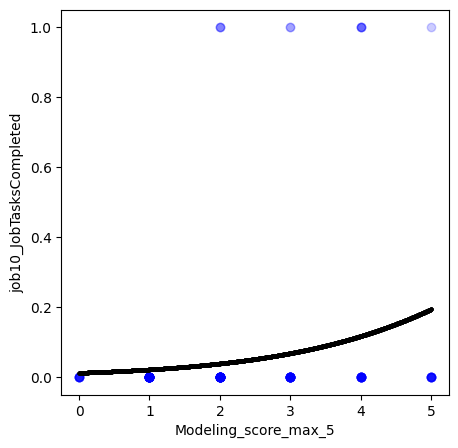

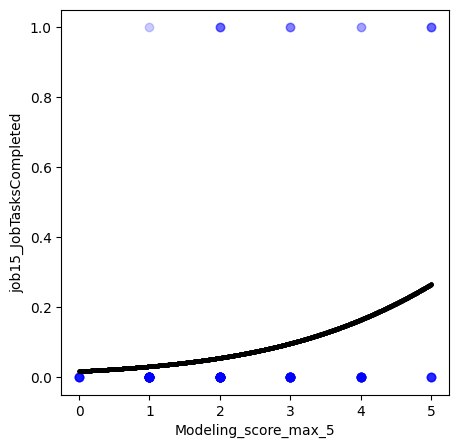

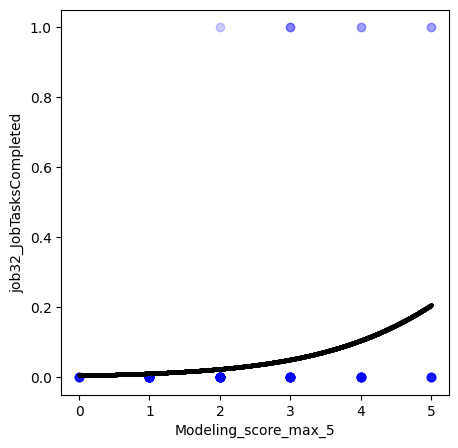

In [ ]:
## JOB 10
pred = 'job10_JobTasksCompleted'
res = 'Modeling_score_max_5'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 15


pred = 'job15_JobTasksCompleted'
res = 'Modeling_score_max_5'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



## JOB 32

pred = 'job32_JobTasksCompleted'
res = 'Modeling_score_max_5'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)




## Logit-bucket analysis Reflection

We need to identify a bucket-distribution that doesn't over-generalize our data. While **_tri_bucket_2** produces results that are borderline statistically significant(talk to Stefan about whether this is a "good" sacrifice to make), we should try to identify a bucket distribution that doesn't clump too many postive and negative results together.

### Static binary bucket

Let's see if we can create a binary set that does a good job of accentuating the shape of our data

#### Permutation 3 Lambda Criteria:

- Top 2 highest get 2
- Rest lowest get 1

In [ ]:
# Create new column for 'Modeling_score_max_5'
df['Modeling_score_max_5_binary_bucket_1'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < 4 else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_1'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < 3 else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_1'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < 4 else 1)
#####################

# Create new column for 'Modeling_score_max_5'
df['Modeling_score_max_5_binary_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Modeling_score_max_5']) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < statistics.median(df['Argument_score_max_4']) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_2'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Experiment_score_max_5']) else 1)




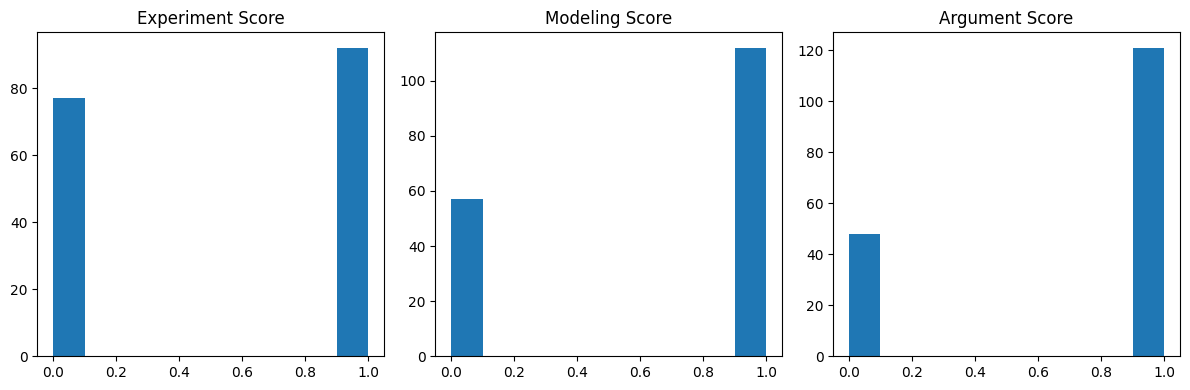

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = df['Experiment_score_max_5_binary_bucket_2']
modeling_score = df['Modeling_score_max_5_binary_bucket_2']
argument_score = df['Argument_score_max_4_binary_bucket_2']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

Recalculating corr coefficients...

In [ ]:

correlation_columns = ['Experiment_score_max_5_binary_bucket_1', 'Modeling_score_max_5_binary_bucket_1', 'Argument_score_max_4_binary_bucket_1']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.01 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

job12_JobTasksCompleted: 0.2867507795491595, 0.0001569653465884487, Argument_score_max_4_binary_bucket_1
job13_JobTasksCompleted: 0.28694893612833045, 0.00015525478511295868, Argument_score_max_4_binary_bucket_1
job32_JobTasksCompleted: 0.23033997432687828, 0.0025883663182104427, Argument_score_max_4_binary_bucket_1


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


INSERT: binary_bucket_2: notice we aren't getting great corr coeffs

In [ ]:

correlation_columns = ['Experiment_score_max_5_binary_bucket_2', 'Modeling_score_max_5_binary_bucket_2', 'Argument_score_max_4_binary_bucket_2']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.05 and pbs.statistic > 0.1: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

job10_JobTasksCompleted: 0.17890803853759407, 0.01994649851466984, Modeling_score_max_5_binary_bucket_2
job10_JobTasksCompleted: 0.15795354282293428, 0.04026206778470385, Argument_score_max_4_binary_bucket_2
job11_JobTasksCompleted: 0.1789080385375941, 0.01994649851466984, Modeling_score_max_5_binary_bucket_2
job11_JobTasksCompleted: 0.15795354282293425, 0.04026206778470385, Argument_score_max_4_binary_bucket_2
job12_JobTasksCompleted: 0.16899518828823562, 0.028059378166606568, Modeling_score_max_5_binary_bucket_2
job12_JobTasksCompleted: 0.18928931616604627, 0.013708084970537859, Argument_score_max_4_binary_bucket_2
job13_JobTasksCompleted: 0.1789080385375941, 0.01994649851466984, Modeling_score_max_5_binary_bucket_2
job13_JobTasksCompleted: 0.15795354282293425, 0.04026206778470385, Argument_score_max_4_binary_bucket_2
job15_JobTasksCompleted: 0.16899518828823562, 0.028059378166606568, Modeling_score_max_5_binary_bucket_2
job15_JobTasksCompleted: 0.18928931616604627, 0.013708084970537

Our corr coeffs are sufficiently low that they would *probably* pass the benjamini-hochberg procedure, although we will come back to verify this later. Let's try with matthews corr coeff for binary data as well(we have to reformat first, let's change our remapped buckets to use 0 and 1 for lambda expression instead of 1 and 2)

In [ ]:

correlation_columns = ['Experiment_score_max_5_binary_bucket_1', 'Modeling_score_max_5_binary_bucket_1', 'Argument_score_max_4_binary_bucket_1']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = sklearn.metrics.matthews_corrcoef(df[corr], df[job])
      if pbs > 0.2: #benjamini hochberg to adjust alpha
        print(f'{pbs},  {job}: {corr}')

0.2867507795491594,  job12_JobTasksCompleted: Argument_score_max_4_binary_bucket_1
0.28694893612833067,  job13_JobTasksCompleted: Argument_score_max_4_binary_bucket_1
0.23033997432687828,  job32_JobTasksCompleted: Argument_score_max_4_binary_bucket_1


Ok, now we might be getting somewhere- Matthews correlation coefficient is supposed to be good for excluding Type 1 and Type 2 Errors(used for this application alot in ML model vetting), and we're obviously getting good agreement between that and point-biserial. Let's see what our distributions of fails/successes looks like in our logit models:

### Binary bucket logits


Optimization terminated successfully.
         Current function value: 0.249317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.443469
         Iterations 6


Text(0, 0.5, 'job33_JobTasksCompleted')

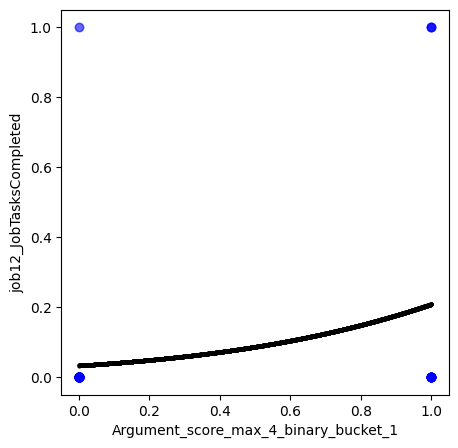

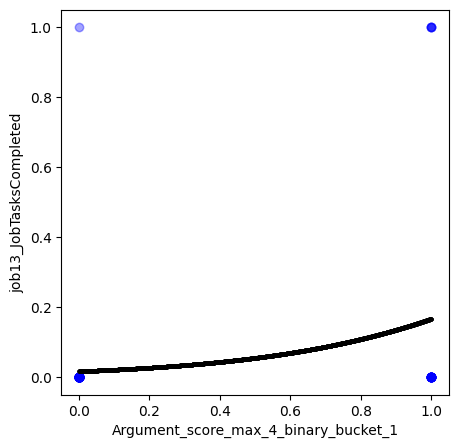

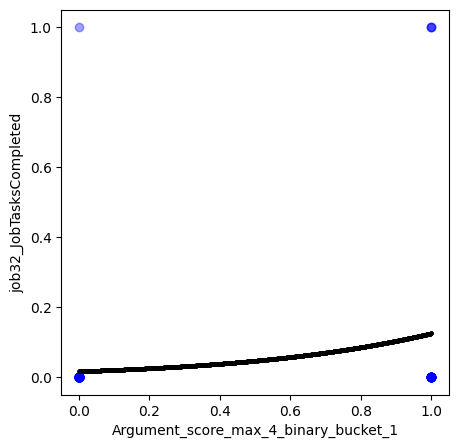

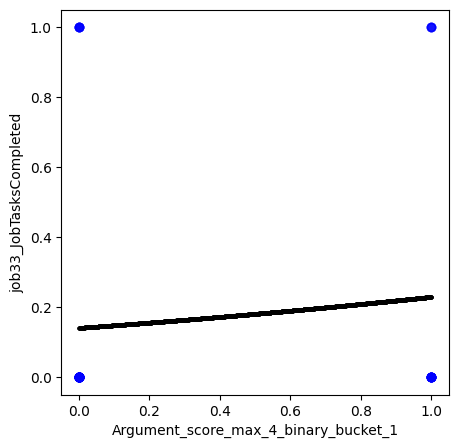

In [ ]:
## JOB 12
pred = 'job12_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_1'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 13


pred = 'job13_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_1'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



## JOB 32

pred = 'job32_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_1'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 32

pred = 'job33_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_1'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



### Intepretation

To me, this seems to be a valid bucket distribution:

- We're still getting the same general features(12, 13, 15, 32...)

- The bucket logic is simple and straightforward

- We can see a clear contrast in poor correlations from other previous tests(I've included a poor correlation in the bottom of the above printout. It is intiuitive to see that good corr coeffs will be yielded by models with a clear dichotomy in successes).

It is very much possible, if not probable, that based on the nature of the questionaire/responses, different categories in evaluation scores have different natural "cutoffs" for the split between "good" and "bad" scores. If we look at the original evaluation distributions, each of the three distributions are dramatically different. It is also worth noting that the previous Tri_bucket_2 score distribution yielded results for the modeling category(normally distributed), and not argumentation, while the binary bucket distribution yielded results only for argumentation. It will be important to establish a systematic way of determining this cutoff that isn't p-hacking.

## Part 5: Re-Running Logistic Regressions with static binary buckets

Let's rerun our logit models with our static binary bucket rule and see how they look.

Printout reminder:

0.2867507795491594,  job12_JobTasksCompleted: Argument_score_max_4_binary_bucket_1
0.28694893612833067,  job13_JobTasksCompleted: Argument_score_max_4_binary_bucket_1
0.23033997432687828,  job32_JobTasksCompleted: Argument_score_max_4_binary_bucket_1

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_1'],
                        df[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.560379
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_1   Log-Likelihood:                -94.704
Model:                                     OrderedModel   AIC:                             193.4
Method:                              Maximum Likelihood   BIC:                             199.7
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          04:43:28                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     2.0411      0.620      3.290      0.001       0.825       3.257
0/1                         1.1246      0.187      6.023      0.000       0.759       1.491
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_1'],
                        df[['job13_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.560289
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_1   Log-Likelihood:                -94.689
Model:                                     OrderedModel   AIC:                             193.4
Method:                              Maximum Likelihood   BIC:                             199.6
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          04:43:46                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     2.4765      0.811      3.052      0.002       0.886       4.067
0/1                         1.0902      0.183      5.965      0.000       0.732       1.448
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_1'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.573414
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_1   Log-Likelihood:                -96.907
Model:                                     OrderedModel   AIC:                             197.8
Method:                              Maximum Likelihood   BIC:                             204.1
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          04:43:51                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     2.1401      0.836      2.560      0.010       0.502       3.779
0/1                         1.0415      0.179      5.803      0.000       0.690       1.393
===========================================================================================
"""

### Interpretation

It seems like we're getting some "cleaner" readouts for our logistic regression models now.

- Odds ratios are above 1(usually significantly) showing a strong correlation and effect on the response variable
- P values are significantly under alpha

In naive testing of other response EMA variables, we're still getting significant results as well- by fine tuning our bucket distributions to match the natural distribution of evaluation response data, we should hopefully be able to establish good "dichotomies" and find other strong correlations for our target features(12,13,32...). We could also try another pass at quartile buckets, although dividing 5 ordinal values 4 ways seems like it could be messy.

## Part 6: Finding Criteria for Buckets - 75th percentile binary

Choosing a specific value threshold for a specific threshold gave us good data, but could be subject to bias/p-hacking and is too subjective. Let's try and use an objective threshold that is consistent across all distributions, and approximates a greater number of successes and failures: we'll go with the 75% percentile range.



In [ ]:
####################
df['Modeling_score_max_5_binary_bucket_3'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 75) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_3'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 75) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_3'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 75) else 1)

In [ ]:
print(np.percentile(df['Experiment_score_max_5'], 75))
print(np.percentile(df['Argument_score_max_4'], 75))
print(np.percentile(df['Modeling_score_max_5'], 75))

5.0
3.0
3.0


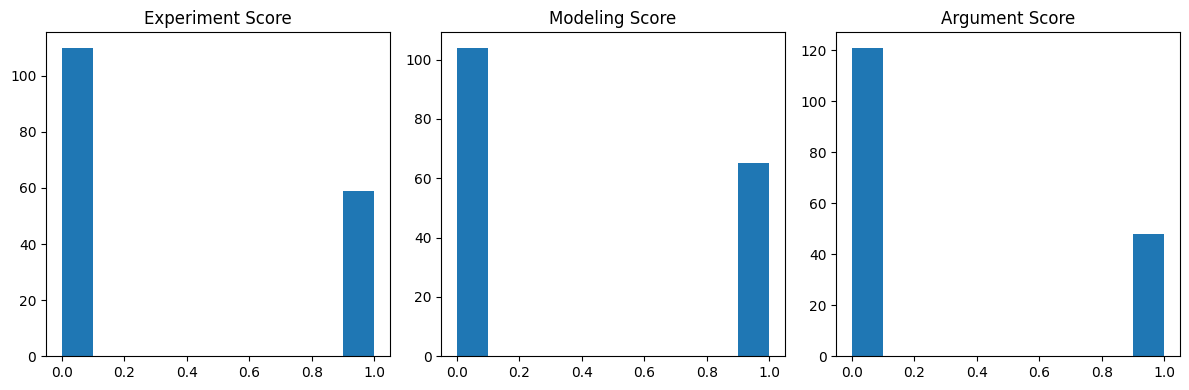

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = df['Experiment_score_max_5_binary_bucket_3']
modeling_score = df['Modeling_score_max_5_binary_bucket_3']
argument_score = df['Argument_score_max_4_binary_bucket_3']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

We have a decent distribution here that pools for a smaller number of successes and is relatively consistent across all distributions- let's check logit/corrs

In [ ]:

correlation_columns = ['Experiment_score_max_5_binary_bucket_3', 'Modeling_score_max_5_binary_bucket_3', 'Argument_score_max_4_binary_bucket_3']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.05 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


job12_JobTasksCompleted: 0.2867507795491595, 0.0001569653465884487, Argument_score_max_4_binary_bucket_3
job13_JobTasksCompleted: 0.28694893612833045, 0.00015525478511295868, Argument_score_max_4_binary_bucket_3
job32_JobTasksCompleted: 0.22468922637101446, 0.0033147995435681807, Modeling_score_max_5_binary_bucket_3
job32_JobTasksCompleted: 0.23033997432687828, 0.0025883663182104427, Argument_score_max_4_binary_bucket_3
job36_JobTasksCompleted: 0.20189796085181236, 0.008479421239586832, Modeling_score_max_5_binary_bucket_3
job38_JobTasksCompleted: 0.20763683999916965, 0.006752038902417528, Modeling_score_max_5_binary_bucket_3


We're seeing alot of the same usual suspects- Let's check the linear regressions

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_3'],
                        df[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.560379
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -94.704
Model:                                     OrderedModel   AIC:                             193.4
Method:                              Maximum Likelihood   BIC:                             199.7
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          06:09:17                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     2.0411      0.620      3.290      0.001       0.825       3.257
0/1                         1.1246      0.187      6.023      0.000       0.759       1.491
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_3'],
                        df[['job13_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.560289
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -94.689
Model:                                     OrderedModel   AIC:                             193.4
Method:                              Maximum Likelihood   BIC:                             199.6
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          06:09:54                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     2.4765      0.811      3.052      0.002       0.886       4.067
0/1                         1.0902      0.183      5.965      0.000       0.732       1.448
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5_binary_bucket_3'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.640458
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Modeling_score_max_5_binary_bucket_3   Log-Likelihood:                -108.24
Model:                                     OrderedModel   AIC:                             220.5
Method:                              Maximum Likelihood   BIC:                             226.7
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          06:11:21                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     2.5202      1.082      2.330      0.020       0.400       4.640
0/1                         0.5743      0.164      3.498      0.000       0.253       0.896
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_3'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.573414
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -96.907
Model:                                     OrderedModel   AIC:                             197.8
Method:                              Maximum Likelihood   BIC:                             204.1
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          06:11:24                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     2.1401      0.836      2.560      0.010       0.502       3.779
0/1                         1.0415      0.179      5.803      0.000       0.690       1.393
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5_binary_bucket_3'],
                        df[['job36_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.645619
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Modeling_score_max_5_binary_bucket_3   Log-Likelihood:                -109.11
Model:                                     OrderedModel   AIC:                             222.2
Method:                              Maximum Likelihood   BIC:                             228.5
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          06:11:40                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job36_JobTasksCompleted     2.3489      1.092      2.150      0.032       0.208       4.490
0/1                         0.5572      0.163      3.413      0.001       0.237       0.877
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5_binary_bucket_3'],
                        df[['job38_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.645158
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Modeling_score_max_5_binary_bucket_3   Log-Likelihood:                -109.03
Model:                                     OrderedModel   AIC:                             222.1
Method:                              Maximum Likelihood   BIC:                             228.3
Date:                                  Tue, 18 Jul 2023                                         
Time:                                          06:11:59                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job38_JobTasksCompleted     1.6884      0.687      2.457      0.014       0.342       3.035
0/1                         0.5898      0.167      3.540      0.000       0.263       0.916
===========================================================================================
"""

### Interpretation
The results here seem pretty good- we still have to run Benjamini Hochberg, but most p-values for logits are well below our alpha. Let's see what the models themselves look like:

### Binary bucket Quartile logits

Optimization terminated successfully.
         Current function value: 0.249317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.167300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151772
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.235113
         Iterations 7


Text(0, 0.5, 'job38_JobTasksCompleted')

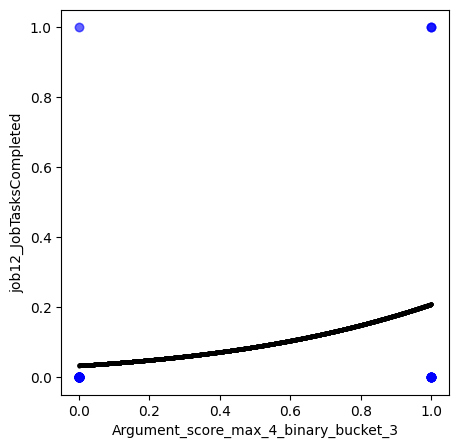

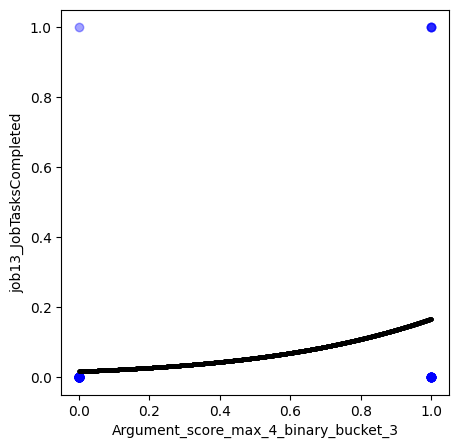

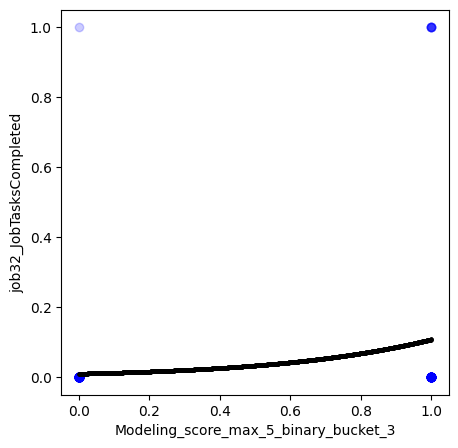

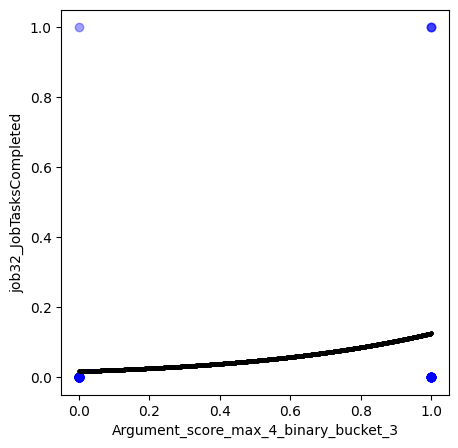

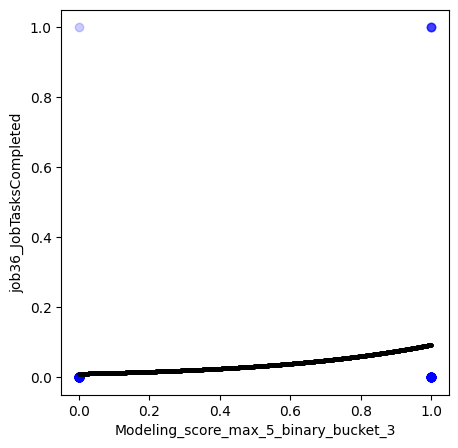

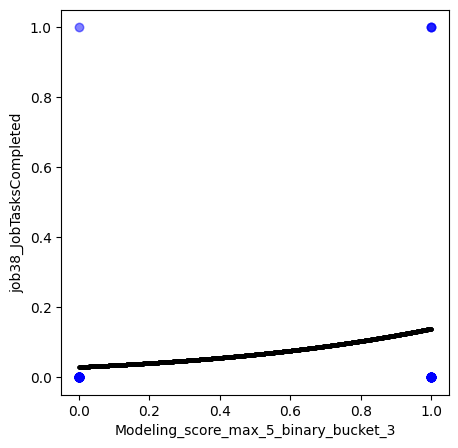

In [ ]:
## AAMAMM
## JOB 12
pred = 'job12_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 13


pred = 'job13_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



## JOB 32

pred = 'job32_JobTasksCompleted'
res = 'Modeling_score_max_5_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 32

pred = 'job32_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


## JOB 36

pred = 'job36_JobTasksCompleted'
res = 'Modeling_score_max_5_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

## JOB 38

pred = 'job38_JobTasksCompleted'
res = 'Modeling_score_max_5_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



### Interpretation

Most of these look pretty good- with most positive outcomes at (1.0, 1.0)- Let's try one more

## Part 7: Finding Criteria for Buckets- 3 way split, 25th, 50th, 75th percentile

Let's try a non-binary value and look at performance.

In [ ]:
q1_mod = df["Modeling_score_max_5"].quantile(0.25)
q2_mod = df["Modeling_score_max_5"].quantile(0.5)
q3_mod = df["Modeling_score_max_5"].quantile(0.75)

print(q1_mod)
print(q2_mod)
print(q3_mod)
print("---")

q1_arg = df["Argument_score_max_4"].quantile(0.25)
q2_arg = df["Argument_score_max_4"].quantile(0.5)
q3_arg = df["Argument_score_max_4"].quantile(0.75)

print(q1_arg)
print(q2_arg)
print(q3_arg)
print("---")

q1_exp = df["Experiment_score_max_5"].quantile(0.25)
q2_exp = df["Experiment_score_max_5"].quantile(0.5)
q3_exp = df["Experiment_score_max_5"].quantile(0.75)

print(q1_exp)
print(q2_exp)
print(q3_exp)




1.0
2.0
3.0
---
0.0
1.0
3.0
---
3.0
4.0
5.0


In [ ]:
df['Modeling_score_max_5_bucket_4'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 25) else (1 if x < np.percentile(df['Modeling_score_max_5'], 50) else (2 if x < np.percentile(df['Modeling_score_max_5'], 75) else 3)))

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_bucket_4'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 25) else (1 if x < np.percentile(df['Argument_score_max_4'], 50) else (2 if x < np.percentile(df['Argument_score_max_4'], 75) else 3)))

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_bucket_4'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 25) else (1 if x < np.percentile(df['Experiment_score_max_5'], 50) else (2 if x < np.percentile(df['Experiment_score_max_5'], 75) else 3)))


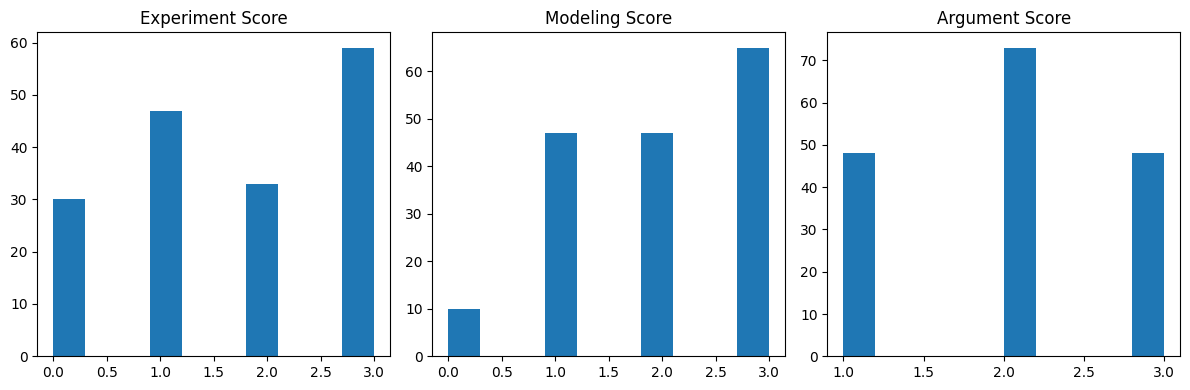

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = df['Experiment_score_max_5_bucket_4']
modeling_score = df['Modeling_score_max_5_bucket_4']
argument_score = df['Argument_score_max_4_bucket_4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

Let's see how our corr coeffs hold up with these distributions

In [ ]:

correlation_columns = ['Experiment_score_max_5_bucket_4', 'Modeling_score_max_5_bucket_4', 'Argument_score_max_4_bucket_4']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.05 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


job12_JobTasksCompleted: 0.28482484444354367, 0.0001745311864681691, Argument_score_max_4_bucket_4
job13_JobTasksCompleted: 0.2661945506280456, 0.0004684464689231448, Argument_score_max_4_bucket_4
job32_JobTasksCompleted: 0.2084634500226531, 0.006530968466247489, Modeling_score_max_5_bucket_4
job32_JobTasksCompleted: 0.22182018065672898, 0.003750022535767553, Argument_score_max_4_bucket_4


The usual suspects- now let's see if this gets rid of our negative value problem we had with previous logit models with ordinal data

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_bucket_4'],
                        df[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.033967
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OrderedModel Results                                  
=========================================================================================
Dep. Variable:     Argument_score_max_4_bucket_4   Log-Likelihood:                -174.74
Model:                              OrderedModel   AIC:                             355.5
Method:                       Maximum Likelihood   BIC:                             364.9
Date:                           Tue, 18 Jul 2023                                         
Time:                                   06:32:26                                         
No. Observations:                            169                                         
Df Residuals:                                166                                         
Df Model:                                      3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     2.1312      0.609      3.502      0.000       0.939       3.324
1/2                        -0.8170      0.174     -4.698      0.000      -1.158      -0.476
2/3                         0.6735      0.102      6.611      0.000       0.474       0.873
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_bucket_4'],
                        df[['job13_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.037382
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OrderedModel Results                                  
=========================================================================================
Dep. Variable:     Argument_score_max_4_bucket_4   Log-Likelihood:                -175.32
Model:                              OrderedModel   AIC:                             356.6
Method:                       Maximum Likelihood   BIC:                             366.0
Date:                           Tue, 18 Jul 2023                                         
Time:                                   06:32:54                                         
No. Observations:                            169                                         
Df Residuals:                                166                                         
Df Model:                                      3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     2.5271      0.805      3.140      0.002       0.950       4.104
1/2                        -0.8455      0.173     -4.892      0.000      -1.184      -0.507
2/3                         0.6649      0.102      6.547      0.000       0.466       0.864
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5_bucket_4'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.218477
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OrderedModel Results                                  
=========================================================================================
Dep. Variable:     Modeling_score_max_5_bucket_4   Log-Likelihood:                -205.92
Model:                              OrderedModel   AIC:                             419.8
Method:                       Maximum Likelihood   BIC:                             432.4
Date:                           Tue, 18 Jul 2023                                         
Time:                                   06:33:14                                         
No. Observations:                            169                                         
Df Residuals:                                165                                         
Df Model:                                      4                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     2.5724      1.076      2.390      0.017       0.463       4.682
0/1                        -2.7187      0.327     -8.325      0.000      -3.359      -2.079
1/2                         0.7474      0.147      5.086      0.000       0.459       1.035
2/3                         0.1716      0.131      1.314      0.189      -0.084       0.428
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_bucket_4'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 1.050713
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OrderedModel Results                                  
=========================================================================================
Dep. Variable:     Argument_score_max_4_bucket_4   Log-Likelihood:                -177.57
Model:                              OrderedModel   AIC:                             361.1
Method:                       Maximum Likelihood   BIC:                             370.5
Date:                           Tue, 18 Jul 2023                                         
Time:                                   06:33:44                                         
No. Observations:                            169                                         
Df Residuals:                                166                                         
Df Model:                                      3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     2.2088      0.824      2.679      0.007       0.593       3.825
1/2                        -0.8639      0.172     -5.012      0.000      -1.202      -0.526
2/3                         0.6493      0.102      6.394      0.000       0.450       0.848
===========================================================================================
"""

###  Interpretation
These models seem more promising, although we'll have to check with Stefan probably. No longer having the issue of non-first level coeffs being negative.